# Построение прогноза временного ряда ДЮЛ Сбербанка в рублях

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

## Нужно построить прогноз временного ряда депозитов юридических лиц Сбербанка в рублях 

### 1. Загрузим и посмотрим на исходную таблицу

In [2]:
all_df = pd.read_csv('allBank_balance_101_sector.csv')
all_df.head()
#sector_id = 1+2+3+4 
#сравнение на последнем годе по метрике MRSE

,report_date,sector_id,bank_group_id,value_rub,value_usd
0,2007-02-01,40,6,9.408740,8.925271
1,2007-02-01,10,6,31.943854,36.274318
2,2007-02-01,41,6,48.045392,20.535636
3,2007-02-01,12,6,4.604419,15.616651
4,2007-02-01,15,6,0.041111,0.000002


### 2. Выберем из таблицы только требуемые данные для построения прогноза 

Sector_id = 1,2,3,4 - четыре сектора соответствуют ДЮЛ; 
Bank_group_id = 1 - банковская группа 1 соответствует Сбербанку

In [3]:
data = all_df.loc[(all_df['sector_id'].isin(['1','2','3','4'])) & (all_df['bank_group_id'] == 1)]
data.head()

,report_date,sector_id,bank_group_id,value_rub,value_usd
467,2007-02-01,2,1,27.283416,0.053730
468,2007-02-01,1,1,0.920018,0.000000
469,2007-02-01,3,1,7.342596,0.567342
470,2007-02-01,4,1,47.034125,154.252131
1402,2007-03-01,2,1,44.244502,0.037278


### 3. Объедимим 4 сектора

In [4]:
df = data[['report_date', 'value_rub']].groupby(['report_date']).sum()
df.head()

,value_rub
report_date,
2007-02-01,82.580155
2007-03-01,105.853892
2007-04-01,130.690753
2007-05-01,150.535440
2007-06-01,163.969009


### Построим график временного ряда и посмотрим его характеристики

In [5]:
df.describe()

,value_rub
count,148.000000
mean,780.431352
std,508.865641
min,82.580155
25%,314.821039
50%,784.213531
75%,1031.420551
max,2520.687992


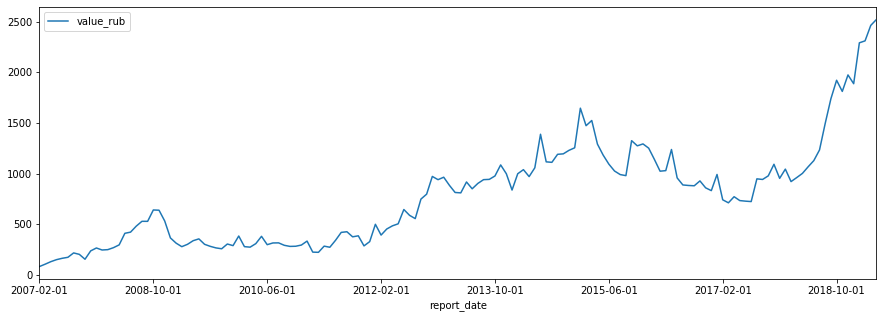

In [6]:
df.plot(figsize=(15,5))

### сглаживание с помощью скользящей средней

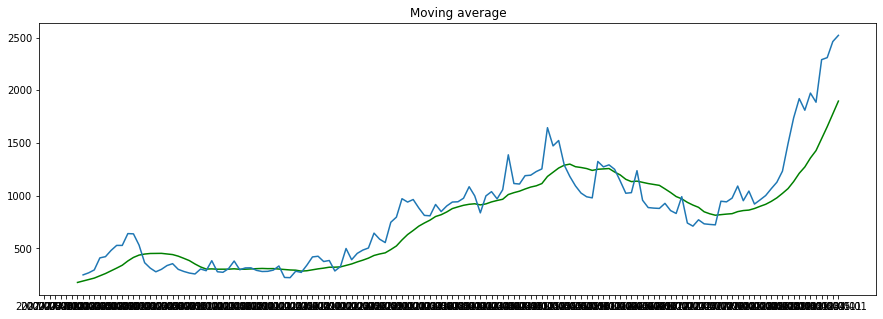

In [7]:
plt.figure(figsize=(15,5))
plt.title('Moving average')
plt.plot(df.rolling(12).mean(), "g", label="Rolling mean trend")

plt.plot(df[12:], label="Actual values")


### Простое экспоненциальное сглаживание

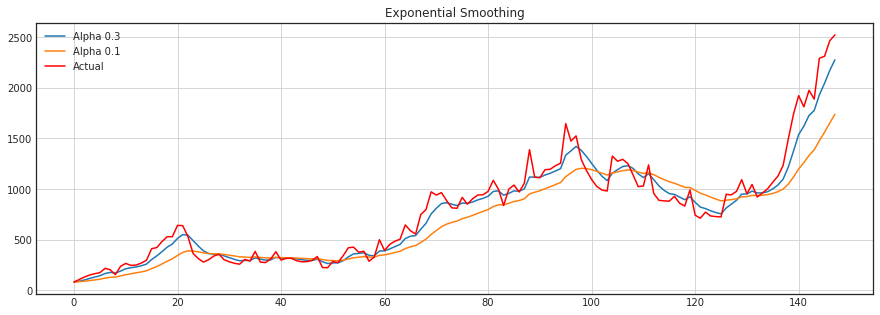

In [8]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(15, 5))
    for alpha in [0.3, 0.1]:
        plt.plot(exponential_smoothing(df.value_rub, alpha), label="Alpha {}".format(alpha))
    plt.plot(df.value_rub.values, "r", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

### Проверка стационарности и STL-декомпозиция ряда

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

Критерий Дики-Фуллера: p=0.994667


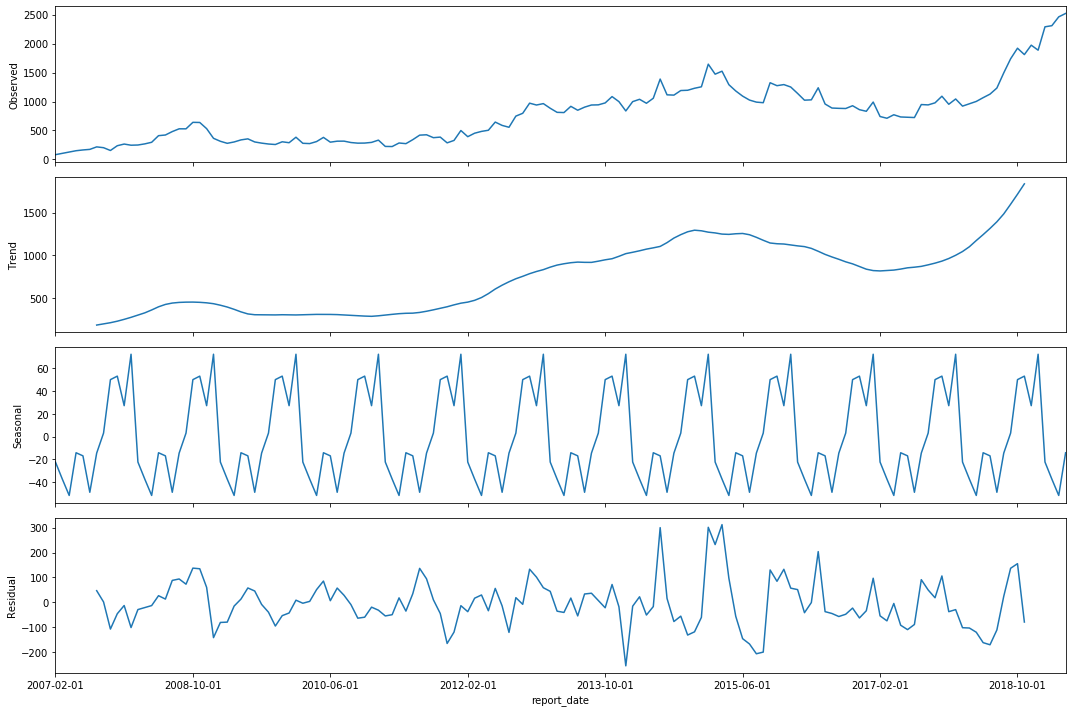

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

from statsmodels.tsa.stattools import adfuller
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.value_rub)[1])

decomposition = seasonal_decompose(df, model='additive',  freq = 12)
fig = decomposition.plot()
plt.show()

### Сделаем преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.234975
Критерий Дики-Фуллера: p=0.624028


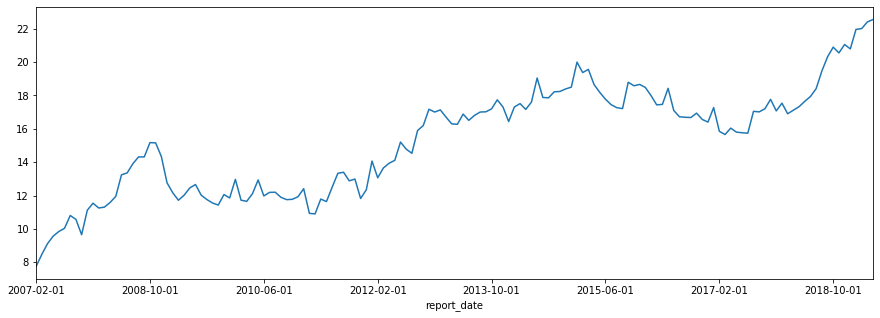

In [11]:
from scipy import stats

df['val_rub'], lmbda = stats.boxcox(df.value_rub)
plt.figure(figsize=(15,5))
df.val_rub.plot()

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.val_rub)[1])

### Попробуем сезонное дифференцирование

Критерий Дики-Фуллера: p=0.383340


<Figure size 1080x720 with 0 Axes>

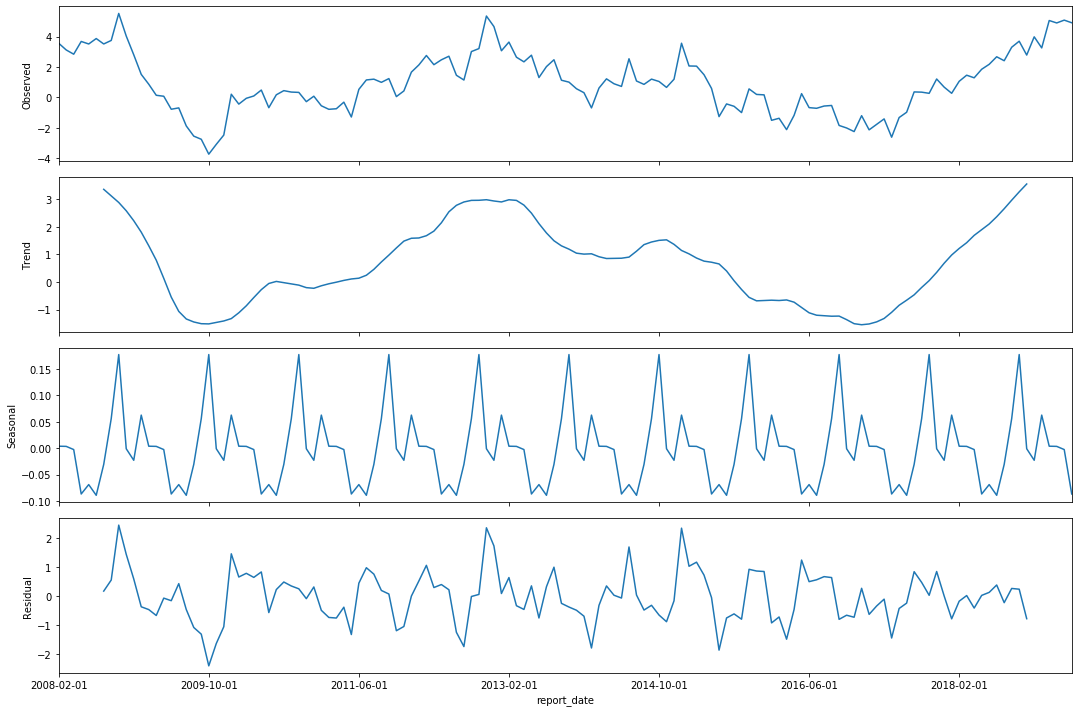

In [12]:
df['val_rub_diff'] = df.val_rub - df.val_rub.shift(12)
plt.figure(figsize=(15,10))
seasonal_decompose(df.val_rub_diff[12:], freq = 12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.val_rub_diff[12:])[1])

####  Добавим обычное дифференцирование

Критерий Дики-Фуллера: p=0.001357


<Figure size 1080x720 with 0 Axes>

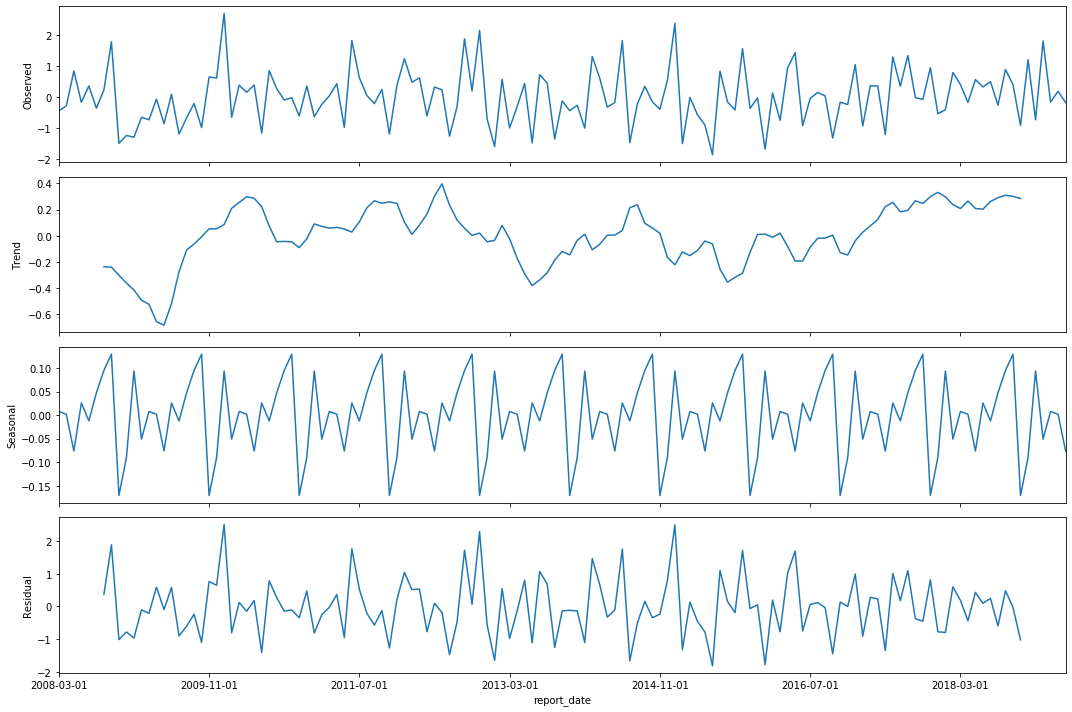

In [13]:
df['val_rub_diff2'] = df.val_rub_diff - df.val_rub_diff.shift(1)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df.val_rub_diff2[13:], freq = 12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.val_rub_diff2[13:])[1])

# Подбор модели

Посмотрим на ACF и PACF полученного ряда

Populating the interactive namespace from numpy and matplotlib


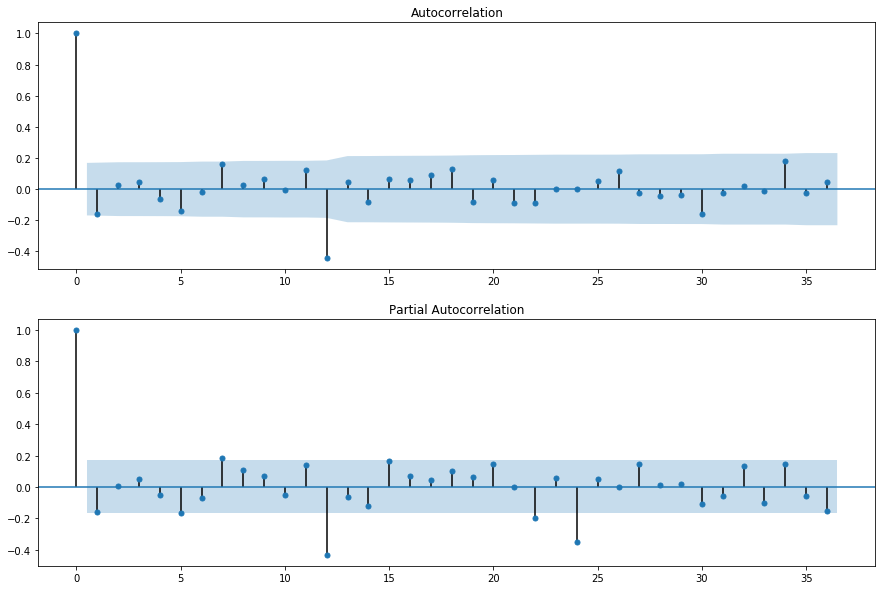

In [14]:
#Посмотрим на ACF и PACF полученного ряда:
%pylab inline
plt.figure(figsize=(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.val_rub_diff2[13:].values.squeeze(), lags=36, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.val_rub_diff2[13:].values.squeeze(), lags=36, ax=ax)
pylab.show()

In [15]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [16]:
import warnings
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [17]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.val_rub, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1min 14s


In [18]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
1   (0, 0, 0, 1)  291.668248
5   (0, 1, 0, 1)  292.363226
13  (1, 0, 0, 1)  292.451425
29  (2, 1, 0, 1)  293.460040
3   (0, 0, 1, 1)  293.648810


### Параметры лучшей модели

In [19]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            val_rub   No. Observations:                  148
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -143.834
Date:                            Tue, 28 Jul 2020   AIC                            291.668
Time:                                    02:09:15   BIC                            297.479
Sample:                                02-01-2007   HQIC                           294.029
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9951      4.418     -0.225      0.822      -9.654       7.664
sigma2         0.3965      1.722   

Критерий Стьюдента: p=0.513987
Критерий Дики-Фуллера: p=0.000000


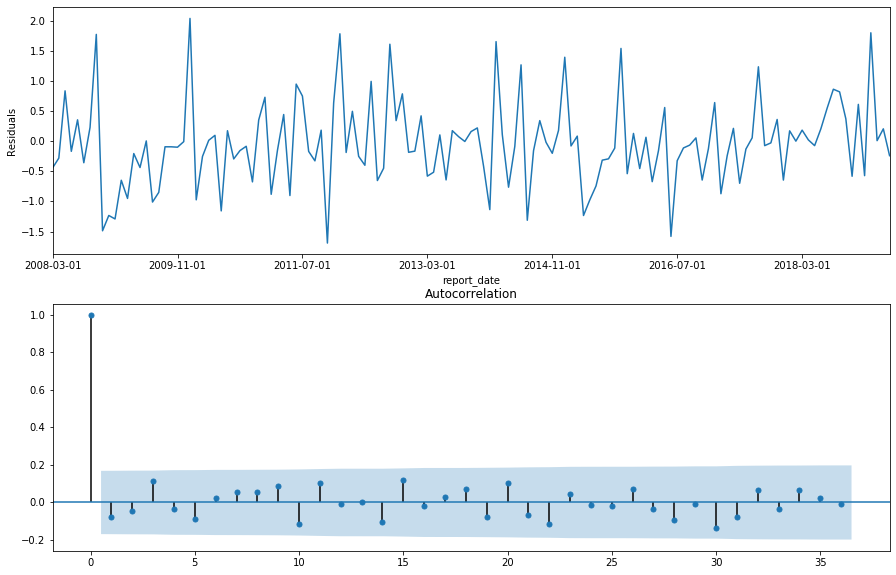

In [20]:
plt.figure(figsize(15,10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=36, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

#### Посмотрим как модель описывает данные

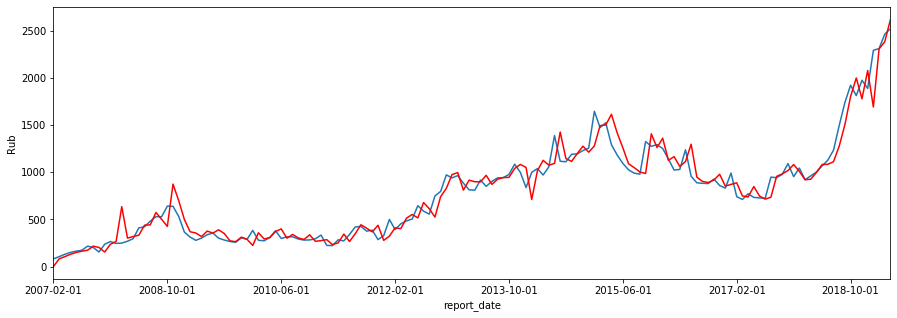

In [21]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,5))
df.value_rub.plot()
df.model.plot(color='r')
plt.ylabel('Rub')
pylab.show()

# Сделаем прогноз на 1 год

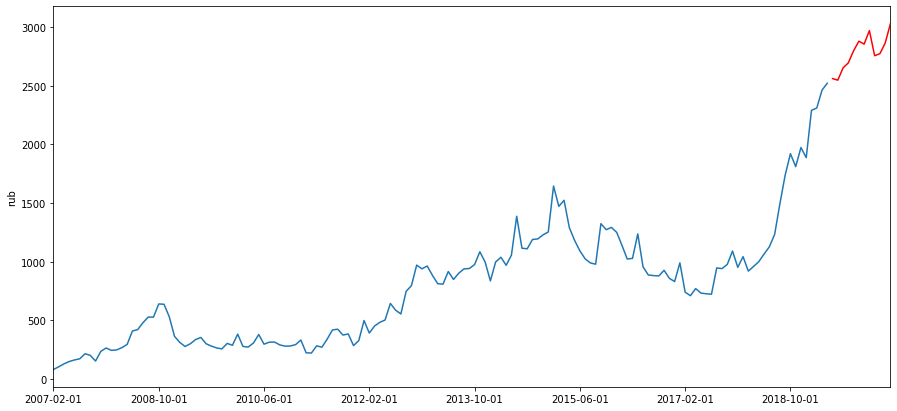

In [22]:
res_df = df[['value_rub']]
date_list = [datetime.datetime.strptime("2019-06-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= res_df.columns)
res_df = pd.concat([res_df, future])
res_df['forecast'] = invboxcox(best_model.predict(start=90, end=300), lmbda)

plt.figure(figsize(15,7))
res_df.value_rub.plot()
res_df.forecast.plot(color='r')
plt.ylabel('rub')
pylab.show()